<img src="./recipe_model_scheme.png" alt="My figure" width="800"/>


In [74]:
# softmax_gp_composition_svgp.py
# Python >= 3.9; pip install numpy pandas scikit-learn tensorflow>=2.10 gpflow>=2.9
# This script:
#   1) loads sensory and ingredient CSVs (joined by 'sample_id'),
#   2) adds an 'Other' ingredient to preserve totals,
#   3) standardizes sensory inputs,
#   4) fits a Softmax-GP (SVGP multi-output) with a Monte-Carlo variational expectation,
#   5) predicts valid compositions (sum to 1, nonnegative),
#   6) (optional) evaluates Aitchison distance via CLR.

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import tensorflow as tf
import gpflow
from gpflow.kernels import RBF
from gpflow.inducing_variables import InducingPoints, SharedIndependentInducingVariables
from gpflow.kernels.multioutput import SeparateIndependent, SharedIndependent
gpflow.config.set_default_float(tf.float64)

In [108]:
# -----------------------------
# Utilities (simplex, CLR, metrics)
# -----------------------------
def to_simplex(rows: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    rows = np.clip(rows, eps, None)
    rows = rows / rows.sum(axis=1, keepdims=True)
    return rows

def clr(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    x = np.clip(x, eps, None)
    g = np.exp(np.mean(np.log(x), axis=1, keepdims=True))
    return np.log(x / g)

def aitchison_distance(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    C1 = clr(y_true, eps)
    C2 = clr(y_pred, eps)
    return np.sqrt(np.sum((C1 - C2) ** 2, axis=1))

def softmax_tf(z, axis=-1):
    zmax = tf.reduce_max(z, axis=axis, keepdims=True)
    ez = tf.exp(z - zmax)
    return ez / tf.reduce_sum(ez, axis=axis, keepdims=True)

# -----------------------------
# Data handling
# -----------------------------
@dataclass
class DataSpec:
    sensory_csv: str
    ingredients_csv: str
    id_col: str = "idx"
    add_other: bool = True
    min_presence: int = 1     # keep an ingredient if present >= this many samples
    scale_X: bool = True

def load_and_align(spec: DataSpec) -> Tuple[pd.DataFrame, pd.DataFrame]:
    Xdf = pd.read_csv(spec.sensory_csv)
    Ydf = pd.read_csv(spec.ingredients_csv)
    df = Xdf.merge(Ydf, on=spec.id_col, how="inner")
    sensory_cols = [c for c in Xdf.columns if c != spec.id_col]
    ingredient_cols = [c for c in Ydf.columns if c != spec.id_col]
    X = df[[spec.id_col] + sensory_cols].copy()
    Y = df[[spec.id_col] + ingredient_cols].copy()
    return X, Y

def build_composition(Y: pd.DataFrame, spec: DataSpec) -> Tuple[np.ndarray, List[str]]:
    id_col = spec.id_col
    cols = [c for c in Y.columns if c != id_col]
    Yvals = Y[cols].to_numpy(dtype=float)

    # If given in 0..100, normalize to 0..1 by row sum
    row_sums = Yvals.sum(axis=1, keepdims=True)
    row_sums = np.where(row_sums == 0.0, 1.0, row_sums)
    Yvals = Yvals / row_sums

    # Presence filter
    present_counts = (Yvals > 0).sum(axis=0)
    keep_mask = present_counts >= spec.min_presence
    kept_cols_raw = [c for c, m in zip(cols, keep_mask) if m]
    Y_keep = Yvals[:, keep_mask]

    if spec.add_other:
        leftover = 1.0 - Y_keep.sum(axis=1)
        other = np.clip(leftover, 0.0, 1.0)
        Y_aug = np.concatenate([Y_keep, other[:, None]], axis=1)
        kept_cols = kept_cols_raw + ["Other"]
    else:
        # Renormalize kept subset
        s = Y_keep.sum(axis=1, keepdims=True)
        s = np.where(s == 0.0, 1.0, s)
        Y_aug = Y_keep / s
        kept_cols = kept_cols_raw

    Y_aug = to_simplex(Y_aug)
    return Y_aug, kept_cols

# -----------------------------
# Softmax-GP custom "likelihood"
# -----------------------------
class SoftmaxCompositional(gpflow.likelihoods.Likelihood):
    """
    Softmax-based compositional likelihood:
      log p(y | f) = tau * sum_k y_k * log softmax(f)_k
    Vector-valued: latent_dim = observation_dim = input_dim = D.
    """

    def __init__(self, D: int, tau: float = 100.0, eps: float = 1e-8):
        super().__init__(input_dim=D, latent_dim=D, observation_dim=D)
        self.D = int(D)
        self.tau = tf.convert_to_tensor(tau, dtype=gpflow.default_float())
        self.eps = tf.convert_to_tensor(eps, dtype=gpflow.default_float())

    # -------- helpers --------
    @staticmethod
    def _softmax(z, axis=-1):
        zmax = tf.reduce_max(z, axis=axis, keepdims=True)
        ez = tf.exp(z - zmax)
        return ez / tf.reduce_sum(ez, axis=axis, keepdims=True)

    def _loglik_point(self, F, Y):
        P = tf.clip_by_value(self._softmax(F), self.eps, 1.0)
        return self.tau * tf.reduce_sum(Y * tf.math.log(P), axis=-1)  # (...,)

    def _mc_sample_f(self, Fmu, Fvar, num_mc: int):
        # Build epsilon from Fvar to guarantee broadcast compatibility
        eps_shape = tf.concat([[num_mc], tf.shape(Fvar)], axis=0)  # (S, N, D)
        eps = tf.random.normal(shape=eps_shape, dtype=Fvar.dtype)
        Fstd = tf.sqrt(tf.maximum(Fvar, 0.0))
        return Fmu[None, ...] + Fstd[None, ...] * eps  # (S, N, D)
    def _ensure_nd_and_cast(self, X, Fmu, Fvar, Y):
        # Cast dtypes
        Fmu = tf.cast(Fmu, gpflow.default_float())
        Fvar = tf.cast(Fvar, gpflow.default_float())
        Y   = tf.cast(Y,   gpflow.default_float())

        # Ranks must be 2: (N, D)
        tf.debugging.assert_rank(Fmu, 2, message="Fmu must be rank-2 [N,D]")
        tf.debugging.assert_rank(Fvar, 2, message="Fvar must be rank-2 [N,D]")
        tf.debugging.assert_rank(Y,   2, message="Y must be rank-2 [N,D]")

        # Match N and D
        n_fmu = tf.shape(Fmu)[0]; d_fmu = tf.shape(Fmu)[1]
        n_fvar= tf.shape(Fvar)[0]; d_fvar= tf.shape(Fvar)[1]
        n_y   = tf.shape(Y)[0];    d_y   = tf.shape(Y)[1]

        tf.debugging.assert_equal(n_fmu, n_fvar, message="N mismatch: Fmu vs Fvar")
        tf.debugging.assert_equal(d_fmu, d_fvar, message="D mismatch: Fmu vs Fvar")
        tf.debugging.assert_equal(n_fmu, n_y,    message="N mismatch: Fmu/Fvar vs Y")
        tf.debugging.assert_equal(d_fmu, d_y,    message="D mismatch: Fmu/Fvar vs Y")

        # One-time shape print (remove after debugging)
        tf.print("[LIK] shapes -> Fmu", tf.shape(Fmu), "Fvar", tf.shape(Fvar), "Y", tf.shape(Y), summarize=-1)
        return Fmu, Fvar, Y

    # -------- required by GPflow Likelihood (note the X arg) --------
    def _log_prob(self, X, F, Y):
        # X is unused, but required by the signature
        return self._loglik_point(F, Y)

    def _variational_expectations(self, X, Fmu, Fvar, Y):
        F_sample = self._mc_sample_f(Fmu, Fvar, num_mc=8)
        logp = self._loglik_point(F_sample, Y[None, ...])  # (S, N)
        return tf.reduce_mean(logp, axis=0)

    def _predict_mean_and_var(self, X, Fmu, Fvar):
        F_sample = self._mc_sample_f(Fmu, Fvar, num_mc=64)
        P = self._softmax(F_sample, axis=-1)              # (S, N, D)
        mean = tf.reduce_mean(P, axis=0)                  # (N, D)
        var  = tf.math.reduce_variance(P, axis=0)         # (N, D)
        mean = tf.clip_by_value(mean, self.eps, 1.0)
        mean = mean / tf.reduce_sum(mean, axis=-1, keepdims=True)
        return mean, var

    def _predict_log_density(self, X, Fmu, Fvar, Y):
        F_sample = self._mc_sample_f(Fmu, Fvar, num_mc=32)
        logp = self._loglik_point(F_sample, Y[None, ...])  # (S, N)
        return tf.reduce_mean(logp, axis=0)

    def predictive_mean_from_moments(self, Fmu, Fvar, mc: int = 64):
        F_sample = self._mc_sample_f(Fmu, Fvar, num_mc=mc)
        P = self._softmax(F_sample, axis=-1)
        mean = tf.reduce_mean(P, axis=0)
        var = tf.math.reduce_variance(P, axis=0)
        mean = tf.clip_by_value(mean, self.eps, 1.0)
        mean = mean / tf.reduce_sum(mean, axis=-1, keepdims=True)
        return mean, var


# -----------------------------
# Build & train the SVGP
# -----------------------------
@dataclass
class ModelConfig:
    num_inducing: int = 20
    ard: bool = True
    tau: float = 100.0
    mc_pred: int = 64
    max_iters: int = 5000
    lr: float = 0.01
    seed: int = 0

def build_svgp_softmax(X: np.ndarray, Y: np.ndarray, cfg: ModelConfig):
    tf.random.set_seed(cfg.seed)
    N, P = X.shape
    D = Y.shape[1]

    M = min(cfg.num_inducing, N)
    perm = np.random.RandomState(cfg.seed).permutation(N)[:M]
    Z = X[perm, :].copy()

    base_kern = RBF(lengthscales=np.ones(P), variance=1.0)  # ARD via vector lengthscales
    kern = SharedIndependent(base_kern, output_dim=D)

    lik = SoftmaxCompositional(D=D, tau=cfg.tau)  # <-- pass D here

    inducing = SharedIndependentInducingVariables(InducingPoints(Z.astype(np.float64)))
    model = gpflow.models.SVGP(
        kernel=kern,
        likelihood=lik,
        inducing_variable=inducing,
        num_latent_gps=D,
        q_diag=True,
        whiten=True,
    )

    # small init for q_var improves stability
    # Zero mean
    model.q_mu.assign(tf.zeros_like(model.q_mu))

    # q_sqrt shape = (L, M) when q_diag=True
    model.q_sqrt.assign(1e-3 * tf.ones_like(model.q_sqrt))

    return model, lik, Z



def train_svgp(
    model,
    X,
    Y,
    cfg: ModelConfig,
    patience: int = 100,       # how many iterations to wait for improvement
    min_delta: float = 1e-5,  # minimal ELBO gain to count as improvement
    verbose: bool = True
):
    """
    Train SVGP with Adam, monitoring ELBO and stopping early if it stalls.

    Args:
        model: gpflow SVGP
        X, Y: training arrays
        cfg: ModelConfig
        patience: stop if no ELBO improvement for this many steps
        min_delta: threshold for "improvement"
        verbose: whether to print progress
    """
    Xtf = tf.convert_to_tensor(X, dtype=tf.float64)
    Ytf = tf.convert_to_tensor(Y, dtype=tf.float64)

    opt = tf.optimizers.Adam(learning_rate=cfg.lr)

    @tf.function(autograph=False)
    def step():
        with tf.GradientTape() as tape:
            elbo = model.elbo((Xtf, Ytf))
            loss = -elbo
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        return elbo

    best_elbo = -np.inf
    wait = 0

    for it in range(cfg.max_iters):
        elbo_val = step().numpy()

        # Check improvement
        if elbo_val > best_elbo + min_delta:
            best_elbo = elbo_val
            wait = 0
        else:
            wait += 1

        # Logging
        if verbose and (it + 1) % 500 == 0:
            print(f"[train] iter {it+1:5d}, ELBO={elbo_val:.4f}, best={best_elbo:.4f}, wait={wait}")

        # Early stop
        if wait >= patience:
            if verbose:
                print(f"[train] Early stopping at iter {it+1}, best ELBO={best_elbo:.4f}")
            break

    return best_elbo

def apply_threshold_and_renorm(P: np.ndarray,
                               thresholds: np.ndarray,
                               mode: str = "per_ingredient",
                               eps: float = 1e-12) -> np.ndarray:
    """
    P: (N, D) predicted fractions on simplex (row-sum ~1)
    thresholds: (D,) per-ingredient thresholds (>0) OR scalar (global)
    mode: "per_ingredient" (default) or "global"
    """
    P = np.nan_to_num(P, nan=0.0, posinf=0.0, neginf=0.0)
    P = np.maximum(P, 0.0)

    if mode == "per_ingredient":
        thr = thresholds.reshape(1, -1)  # (1, D)
    elif mode == "global":
        thr = float(thresholds)          # scalar
    else:
        raise ValueError("mode must be 'per_ingredient' or 'global'")

    # Zero out entries below threshold
    P_thr = P.copy()
    P_thr[P_thr < thr] = 0.0

    # Renormalize row-wise; if a row becomes all-zero, fallback to original P
    row_sums = P_thr.sum(axis=1, keepdims=True)
    fallback_mask = (row_sums <= eps).ravel()
    if np.any(fallback_mask):
        # keep original for those rows (or you could distribute uniformly)
        P_thr[fallback_mask] = P[fallback_mask]
        row_sums[fallback_mask] = P[fallback_mask].sum(axis=1, keepdims=True)

    P_thr = P_thr / np.maximum(row_sums, 1.0)  # safe divide
    return P_thr

# -----------------------------
# Predictions
# -----------------------------
def predict_composition(model, Xnew: np.ndarray, mc_samples: int = 64) -> np.ndarray:
    """
    Returns predictive mean composition (N*, D) by MC over q(f).
    """
    Xtf = tf.convert_to_tensor(Xnew, dtype=tf.float64)
    Fmu, Fvar = model.predict_f(Xtf, full_cov=False, full_output_cov=False)
    lik: SoftmaxCompositional = model.likelihood  # type: ignore
    Pmean, Pvar = lik.predictive_mean_from_moments(Fmu, Fvar, mc=mc_samples)
    # Ensure valid simplex numerically
    Pmean = to_simplex(Pmean)
    return Pmean, Pvar
def renorm_simplex(A: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """
    Force rows to be valid simplex:
      - replace NaN/Inf with 0
      - clamp negatives to 0
      - renormalize row-wise to sum exactly 1
    """
    A = np.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)
    A = np.maximum(A, 0.0)
    s = A.sum(axis=1, keepdims=True)
    s[s <= eps] = 1.0  # avoid div-by-zero: keep all-zero rows as zeros
    return A / s
# -----------------------------
# End-to-end pipeline
# -----------------------------
def run_pipeline(
    sensory_csv: str,
    ingredients_csv: str,
    id_col: str = "sample_id",
    min_presence: int = 1,
    add_other: bool = True,
    num_inducing: int = 20,
    tau: float = 100.0,
    max_iters: int = 5000,
    do_loocv: bool = True,
    seed: int = 0
) -> Dict:
    spec = DataSpec(
        sensory_csv=sensory_csv,
        ingredients_csv=ingredients_csv,
        id_col=id_col,
        add_other=add_other,
        min_presence=min_presence,
        scale_X=True
    )

    # Load
    Xdf, Ydf = load_and_align(spec)
    meds = Xdf.iloc[:,1:].median(axis=0)
    Xdf = Xdf.fillna(meds)
    Ydf = Ydf.fillna(0)
    X_cols = [c for c in Xdf.columns if c != id_col]
    X_raw = Xdf[X_cols].to_numpy(dtype=float)
    Y_mat, ing_names = build_composition(Ydf, spec)  # (N, D)

    # Per-ingredient minimum strictly > 0 observed in training data
    nz = np.where(Y_mat > 0, Y_mat, np.nan)
    per_ing_min = np.nanmin(nz, axis=0)         # shape (D,)
    per_ing_min = np.where(np.isfinite(per_ing_min), per_ing_min, 0.0)  # if an ingredient is always 0

    # # Optional: global minimum > 0 (if you ever want a single scalar threshold)
    # valid = nz[nz > 1e-5]

    # if valid.size > 0:
    #     global_min = float(np.min(valid))
    # else:
    #     global_min = 0.0  # fallback if no values above threshold
    global_min = 0.0005
    # Standardize X
    xscaler = StandardScaler().fit(X_raw)
    X = xscaler.transform(X_raw)

    # Build + train model
    cfg = ModelConfig(
        num_inducing=num_inducing, tau=tau, max_iters=max_iters, seed=seed, lr=0.01, ard=True
    )
    model, lik, Z = build_svgp_softmax(X, Y_mat, cfg)

    train_svgp(model, X, Y_mat, cfg)

    artifacts = {
        "xscaler": xscaler,
        "x_imputer": meds,          # <-- store the training medians
        "model": model,
        "ingredient_names": ing_names,
        "X_cols": X_cols,
        "id_col": id_col,
        "config": cfg.__dict__,
        "threshold_global": global_min
    }

    n = X.shape[0]
    run_cv = bool(do_loocv)
    n_splits = None
    scheme = None

    if do_loocv is True:
        n_splits = n
        scheme = "LOOCV"
    elif isinstance(do_loocv, int) and do_loocv >= 2:
        n_splits = min(do_loocv, n)  # cap at N
        scheme = f"{n_splits}-Fold CV"

    if run_cv and n_splits is not None and n_splits >= 2:
        # We will CV on *raw* X (before full-data scaling) to avoid leakage.
        # Recreate raw X and fixed Y from the same columns used to train the full model.
        X_raw_full = Xdf[X_cols].to_numpy(dtype=float)  # raw (post-imputation only for final model)
        Y_full = Y_mat                                  # (N, D) fixed composition columns

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        ad_all, l2_all = [], []

        for fold_idx, (tr_idx, te_idx) in enumerate(kf.split(X_raw_full), 1):
            # --- Train split: imputer + scaler fit only on TRAIN ---
            Xtr_raw = X_raw_full[tr_idx]
            Xte_raw = X_raw_full[te_idx]

            # Impute with training medians (column-wise)
            meds_tr = np.nanmedian(Xtr_raw, axis=0)
            # If a column is entirely NaN, replace nanmedian with 0
            meds_tr = np.where(np.isfinite(meds_tr), meds_tr, 0.0)
            Xtr_imp = np.where(np.isnan(Xtr_raw), meds_tr[None, :], Xtr_raw)
            Xte_imp = np.where(np.isnan(Xte_raw), meds_tr[None, :], Xte_raw)

            # Scale with training scaler
            scaler_tr = StandardScaler().fit(Xtr_imp)
            # Guard zero-variance columns
            if hasattr(scaler_tr, "scale_"):
                zero_scale = (scaler_tr.scale_ == 0)
                if np.any(zero_scale):
                    scaler_tr.scale_[zero_scale] = 1.0
                    if hasattr(scaler_tr, "var_"):
                        scaler_tr.var_[zero_scale] = 1.0

            Xtr = scaler_tr.transform(Xtr_imp)
            Xte = scaler_tr.transform(Xte_imp)

            # Targets
            Ytr, Yte = Y_full[tr_idx], Y_full[te_idx]

            # Build & train fold model
            cfg_cv = ModelConfig(
                num_inducing=min(cfg.num_inducing, Xtr.shape[0]),
                tau=cfg.tau,
                max_iters=max(1, int(max_iters / 2)),   # faster per fold
                seed=seed,
                lr=cfg.lr,
                ard=True
            )
            m_cv, _, _ = build_svgp_softmax(Xtr, Ytr, cfg_cv)
            train_svgp(m_cv, Xtr, Ytr, cfg_cv)

            # Predict on test split
            Yhat, _ = predict_composition(m_cv, Xte, mc_samples=cfg.mc_pred)

            # Metrics
            ad = aitchison_distance(Yte, Yhat)
            l2 = np.sqrt(np.sum((Yte - Yhat) ** 2, axis=1))
            ad_all.extend(list(ad))
            l2_all.extend(list(l2))

        artifacts["cv"] = {
            "scheme": scheme,
            "folds": int(n_splits),
            "aitchison_mean": float(np.mean(ad_all)),
            "aitchison_std":  float(np.std(ad_all)),
            "l2_mean":        float(np.mean(l2_all)),
            "l2_std":         float(np.std(l2_all)),
            "n_samples":      int(n),
        }

    return artifacts

def predict_from_artifacts(artifacts: Dict, X_new: pd.DataFrame) -> pd.DataFrame:
    X_cols = artifacts["X_cols"]
    xscaler = artifacts["xscaler"]
    x_imputer = artifacts["x_imputer"]      # <-- use the stored medians
    model = artifacts["model"]
    ing_names = artifacts["ingredient_names"]

    per_ing_min = artifacts.get("thresholds_per_ingredient", None)
    global_min  = artifacts.get("threshold_global", None)
    # print("global min", global_min)
    # Make a copy, ensure order, impute
    Xarr_df = X_new[X_cols].astype(float).copy()
    Xarr_df = Xarr_df.fillna(x_imputer)

    # (Optional) if any constant columns at train time, skip second check here
    Xs = xscaler.transform(Xarr_df.values)

    # Simple finite check (see Patch C)
    assert np.isfinite(Xs).all(), "Xs has non-finite values after impute+scale."

    Yhat, vars = predict_composition(model, Xs, mc_samples=artifacts["config"].get("mc_pred", 64))
    Yhat_pct = 100 * Yhat    # ---- Apply thresholding ----
    if global_min is not None:
        # Per-ingredient thresholding (recommended)
        # Yhat = apply_threshold_and_renorm(Yhat, per_ing_min, mode="per_ingredient")
        # If you prefer a single global threshold, use:
        Yhat = apply_threshold_and_renorm(Yhat, global_min, mode="global")

    # Final sanity
    Yhat = renorm_simplex(Yhat)
    Yhat_pct = 100.0 * Yhat
    return pd.DataFrame(Yhat_pct, columns=ing_names, index=X_new.index), pd.DataFrame(vars, columns=ing_names, index=X_new.index)

In [104]:
# -----------------------------
# Example usage
# -----------------------------

SENSORY_CSV = "../../data/recipes/data_sens.csv"      # columns: sample_id, s1..s8
ING_CSV     = "../../data/recipes/data_recipe.csv"  # columns: sample_id, many ingredients (0..100 or 0..1)

artifacts = run_pipeline(
    sensory_csv=SENSORY_CSV,
    ingredients_csv=ING_CSV,
    id_col="idx",
    min_presence=10,     # keep all ingredients as separate cols (rare ones flow into 'Other')
    add_other=True,
    num_inducing=20,
    tau=150.0,          # try 50..300; larger -> sharper fits to observed compositions
    max_iters=4000,
    do_loocv=5,
    seed=0
)

if "cv" in artifacts:
    print("LOOCV Aitchison mean±std:",
            artifacts["cv"]["aitchison_mean"], "±", artifacts["cv"]["aitchison_std"])
    print("LOOCV L2 mean±std:",
            artifacts["cv"]["l2_mean"], "±", artifacts["cv"]["l2_std"])

# Demo predictions on the same X (replace with your new sensory rows)
Xdf, Ydf = load_and_align(DataSpec(SENSORY_CSV, ING_CSV))
preds, vars = predict_from_artifacts(artifacts, Xdf.drop(columns=["idx"]))
print(preds.head())


[train] iter   500, ELBO=-17178.7801, best=-17081.9217, wait=5
[train] iter  1000, ELBO=-16614.8699, best=-16465.6411, wait=57
[train] Early stopping at iter 1043, best ELBO=-16465.6411
[train] iter   500, ELBO=-13281.2403, best=-13132.7841, wait=21
[train] iter  1000, ELBO=-12806.0307, best=-12743.4851, wait=91
[train] Early stopping at iter 1102, best ELBO=-12717.6191
[train] iter   500, ELBO=-13900.6225, best=-13859.8058, wait=37
[train] Early stopping at iter 995, best ELBO=-13424.5979
[train] iter   500, ELBO=-13096.4439, best=-13014.8722, wait=19
[train] Early stopping at iter 984, best ELBO=-12458.9036
[train] iter   500, ELBO=-13132.4206, best=-13118.0965, wait=6
[train] Early stopping at iter 859, best ELBO=-12758.0980
[train] iter   500, ELBO=-13904.8868, best=-13749.3693, wait=3
[train] iter  1000, ELBO=-13116.3552, best=-12928.0596, wait=22
[train] Early stopping at iter 1078, best ELBO=-12928.0596
LOOCV Aitchison mean±std: 31.779938522841025 ± 2.7237132457502327
LOOCV L2 m

In [152]:
# =========================================
# TSNE + plotting utilities (compatible with your predict_from_artifacts)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# ---------- X preprocessing with artifacts ----------
def _ensure_order_impute_scale(Xdf: pd.DataFrame, artifacts: dict) -> np.ndarray:
    X_cols = artifacts["X_cols"]
    x_imputer = artifacts.get("x_imputer", None)
    xscaler = artifacts["xscaler"]
    Xarr_df = Xdf[X_cols].astype(float).copy()
    Xarr_df = Xarr_df.fillna(x_imputer) if x_imputer is not None else Xarr_df.fillna(0.0)
    Xs = xscaler.transform(Xarr_df.values)
    if not np.isfinite(Xs).all():
        raise ValueError("Non-finite values after scaling X.")
    return Xs

# ---------- Y alignment to artifacts (returns PERCENTAGES) ----------
def _align_Y_percent(Ydf: pd.DataFrame, artifacts: dict) -> pd.DataFrame:
    """
    Align Y to artifacts['ingredient_names'], reconstruct 'Other' if needed, return percentages (sum to 100).
    """
    id_col = artifacts["id_col"]
    ing_names = artifacts["ingredient_names"]
    y_cols = [c for c in Ydf.columns if c != id_col]
    Yraw = Ydf[y_cols].astype(float).fillna(0.0).to_numpy()
    row_sums = Yraw.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0.0] = 1.0
    Ynorm = Yraw / row_sums  # fractions
    Ynorm_df = pd.DataFrame(Ynorm, columns=y_cols, index=Ydf.index)

    if "Other" in ing_names:
        base = [c for c in ing_names if c != "Other"]
        present = [c for c in base if c in Ynorm_df.columns]
        Ykeep = Ynorm_df[present].to_numpy()
        missing = [c for c in base if c not in present]
        if missing:
            Ykeep = np.column_stack([Ykeep] + [np.zeros((Ykeep.shape[0], 1)) for _ in missing])
            present = present + missing
        order_idx = [present.index(c) for c in base]
        Ykeep = Ykeep[:, order_idx]
        leftover = np.clip(1.0 - Ykeep.sum(axis=1, keepdims=True), 0.0, 1.0)
        Yal = np.concatenate([Ykeep, leftover], axis=1)
    else:
        base = list(ing_names)
        present = [c for c in base if c in Ynorm_df.columns]
        Ykeep = Ynorm_df[present].to_numpy()
        missing = [c for c in base if c not in present]
        if missing:
            Ykeep = np.column_stack([Ykeep] + [np.zeros((Ykeep.shape[0], 1)) for _ in missing])
            present = present + missing
        order_idx = [present.index(c) for c in base]
        Yal = Ykeep[:, order_idx]

    Ypct = 100.0 * (Yal.T / np.maximum(Yal.sum(axis=1), 1e-12)).T
    return pd.DataFrame(Ypct, columns=ing_names, index=Ydf.index)

# ---------- t-SNE fit (on preprocessed X) + kNN for new point placement ----------
def fit_tsne_from_artifacts(Xdf: pd.DataFrame, artifacts: dict, perplexity: float = 20.0, random_state: int = 0):
    """
    Returns:
      Xs: (N,P) scaled inputs,
      proj2d: (N,2) t-SNE coordinates,
      nn: NearestNeighbors on Xs for barycentric placement of new samples.
    """
    Xs = _ensure_order_impute_scale(Xdf, artifacts)
    tsne = TSNE(n_components=2, perplexity=perplexity, init="random", random_state=random_state)
    proj2d = tsne.fit_transform(Xs)
    nn = NearestNeighbors(n_neighbors=min(10, len(Xs)), metric="euclidean").fit(Xs)
    return Xs, proj2d, nn

def _place_new_point_tsne(Xs: np.ndarray, proj2d: np.ndarray, nn: NearestNeighbors, x_row: np.ndarray, k: int = 10):
    k = min(k, Xs.shape[0])
    dists, idxs = nn.kneighbors(x_row.reshape(1, -1), n_neighbors=k)
    d = dists[0]; I = idxs[0]
    if np.any(d == 0):
        return proj2d[I[np.argmin(d)]]
    w = 1.0 / d; w /= w.sum()
    return (proj2d[I] * w[:, None]).sum(axis=0)

# ---------- small adapter over YOUR predict_from_artifacts ----------
def _predict_means_vars_pct(artifacts: dict, X_like_df: pd.DataFrame):
    """
    Calls your predict_from_artifacts and always returns (mean_pct_df, var_df or None).
    Your function returns (means_in_percent, vars_in_fraction).
    """
    mean_pct_df, var_df = predict_from_artifacts(artifacts, X_like_df)
    return mean_pct_df, var_df

# ---------- ingredient bar plot for one sample ----------
def plot_ingredients_for_sample(sens_vars,
                                artifacts: dict,
                                ingredients_pct: np.ndarray | pd.Series | None = None,
                                show_variance: bool = True,
                                title: str = "Ingredients (mean ± uncertainty)"):
    """
    If ingredients_pct is None: uses YOUR model to estimate mean (%)
    and variance (fraction units) then plots mean (%) with error bars = sqrt(var)*100.
    sens_vars: dict / Series / 1D array ordered by artifacts["X_cols"].
    """
    X_cols = artifacts["X_cols"]
    ing_names = artifacts["ingredient_names"]

    # 1-row DataFrame in right order
    if isinstance(sens_vars, dict):
        row_df = pd.DataFrame([sens_vars])[X_cols].astype(float)
    elif isinstance(sens_vars, pd.Series):
        row_df = pd.DataFrame([sens_vars.values], columns=sens_vars.index)[X_cols].astype(float)
    else:
        row_df = pd.DataFrame([sens_vars], columns=X_cols).astype(float)

    if ingredients_pct is None:
        mean_pct_df, var_df = _predict_means_vars_pct(artifacts, row_df)
        comp_pct = mean_pct_df.iloc[0].to_numpy()  # percentages
        var_frac = var_df.iloc[0].to_numpy() if (show_variance and var_df is not None) else None
    else:
        comp_pct = np.asarray(ingredients_pct, dtype=float).ravel()
        comp_pct = 100.0 * (comp_pct / max(comp_pct.sum(), 1e-12))
        var_frac = None

    x = np.arange(len(ing_names))
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(x, comp_pct, alpha=0.9, label="Predicted mean")

    if show_variance and (var_frac is not None):
        err_pct = 100.0 * np.sqrt(np.maximum(var_frac, 0.0))  # convert fraction std to percent std
        ax.errorbar(x, comp_pct, yerr=err_pct, fmt="none", capsize=3, ecolor="k", label="±1σ")

    ax.set_xticks(x)
    ax.set_xticklabels(ing_names, rotation=45, ha="right")
    ax.set_ylim(0, max(5, comp_pct.max() * 1.2))
    ax.set_ylabel("Percent")
    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# ---------- projection plot ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.gridspec import GridSpec

# --- helper to get 1-row X in correct order + scaled ---
def _ensure_order_impute_scale_row(sens_vars, artifacts: dict) -> np.ndarray:
    X_cols = artifacts["X_cols"]
    x_imputer = artifacts.get("x_imputer", None)
    xscaler = artifacts["xscaler"]
    # Build a 1-row DataFrame in the right order
    if isinstance(sens_vars, dict):
        row_df = pd.DataFrame([sens_vars])[X_cols].astype(float)
    elif isinstance(sens_vars, pd.Series):
        row_df = pd.DataFrame([sens_vars.values], columns=sens_vars.index)[X_cols].astype(float)
    else:
        row_df = pd.DataFrame([sens_vars], columns=X_cols).astype(float)
    row_df = row_df.fillna(x_imputer) if x_imputer is not None else row_df.fillna(0.0)
    x_row = xscaler.transform(row_df.values)
    return x_row, row_df  # scaled row (np array), and the original 1-row DF for predict_from_artifacts

# --- adapter over your predict_from_artifacts (returns mean % and var (frac)) ---
def _predict_means_vars_pct(artifacts: dict, X_like_df: pd.DataFrame):
    out = predict_from_artifacts(artifacts, X_like_df)
    if isinstance(out, tuple) and len(out) == 2:
        mean_pct_df, var_df = out
    elif isinstance(out, dict) and ("mean" in out or "var" in out):
        mean_pct_df = out.get("mean")
        var_df = out.get("var")
    else:
        mean_pct_df, var_df = out, None
    return mean_pct_df, var_df

# --- barycentric placement in t-SNE space using kNN on original Xs ---
def _place_new_point_tsne(Xs: np.ndarray, proj2d: np.ndarray, nn, x_row: np.ndarray, k: int = 10):
    k = min(k, Xs.shape[0])
    dists, idxs = nn.kneighbors(x_row.reshape(1, -1), n_neighbors=k)
    d = dists[0]; I = idxs[0]
    if np.any(d == 0):
        return proj2d[I[np.argmin(d)]]
    w = 1.0 / d; w /= w.sum()
    return (proj2d[I] * w[:, None]).sum(axis=0)

def plot_projection(proj2d: np.ndarray,
                    artifacts: dict,
                    ingredient: str | None = None,
                    *,
                    Xdf: pd.DataFrame | None = None,
                    Ydf: pd.DataFrame | None = None,
                    Xs: np.ndarray | None = None,
                    nn = None,
                    sample_sens: dict | pd.Series | np.ndarray | None = None,
                    show_variance: bool = True,
                    point_size: int = 40,
                    color_by: str = "prediction"):
    """
    proj2d: (N,2) t-SNE coords for rows in Xdf used to fit the embedding.
    ingredient: optional ingredient to color points by (%).
    If sample_sens is provided:
      - places the sample (using kNN barycentric in t-SNE),
      - draws a RED CIRCLE around it,
      - shows its ingredients bar chart BESIDE the scatter.
    """
    ing_names = artifacts["ingredient_names"]

    # If placing a sample, build a side-by-side layout
    if sample_sens is not None:
        fig = plt.figure(figsize=(13, 6))
        gs = GridSpec(1, 2, width_ratios=[1.0, 1.0], wspace=0.25)
        ax_scat = fig.add_subplot(gs[0, 0])
        ax_bar  = fig.add_subplot(gs[0, 1])
    else:
        fig, ax_scat = plt.subplots(figsize=(6, 6))
        ax_bar = None

    # ---- Scatter base / coloring ----
    if ingredient is not None:
        if ingredient not in ing_names:
            raise ValueError(f"Ingredient '{ingredient}' not in trained ingredients.")
        if color_by == "prediction":
            if Xdf is None:
                raise ValueError("Provide Xdf to color by prediction.")
            mean_pct_df, _ = _predict_means_vars_pct(artifacts, Xdf[artifacts["X_cols"]].astype(float))
            cvals = mean_pct_df[ingredient].to_numpy()
            sc = ax_scat.scatter(proj2d[:, 0], proj2d[:, 1], s=point_size, c=cvals)
            plt.colorbar(sc, ax=ax_scat, label=f"{ingredient} (%) — predicted")
        elif color_by == "truth":
            if Ydf is None:
                raise ValueError("Provide Ydf to color by truth.")
            # align Y to artifacts, in %
            id_col = artifacts["id_col"]
            y_cols = [c for c in Ydf.columns if c != id_col]
            Yraw = Ydf[y_cols].astype(float).fillna(0.0).to_numpy()
            rs = Yraw.sum(axis=1, keepdims=True); rs[rs == 0.0] = 1.0
            Ynorm = Yraw / rs
            Ypct = 100.0 * (Ynorm.T / np.maximum(Ynorm.sum(axis=1), 1e-12)).T
            Ypct_df = pd.DataFrame(Ypct, columns=y_cols, index=Ydf.index)
            # reconstruct "Other" if needed
            if "Other" in ing_names:
                base = [c for c in ing_names if c != "Other"]
                present = [c for c in base if c in Ypct_df.columns]
                Ykeep = Ypct_df[present].to_numpy()
                missing = [c for c in base if c not in present]
                if missing:
                    Ykeep = np.column_stack([Ykeep] + [np.zeros((Ykeep.shape[0], 1)) for _ in missing])
                    present = present + missing
                order_idx = [present.index(c) for c in base]
                Ykeep = Ykeep[:, order_idx]
                leftover = np.clip(100.0 - Ykeep.sum(axis=1, keepdims=True), 0.0, 100.0)
                Yal_pct = np.concatenate([Ykeep, leftover], axis=1)
            else:
                base = list(ing_names)
                present = [c for c in base if c in Ypct_df.columns]
                Ykeep = Ypct_df[present].to_numpy()
                missing = [c for c in base if c not in present]
                if missing:
                    Ykeep = np.column_stack([Ykeep] + [np.zeros((Ykeep.shape[0], 1)) for _ in missing])
                    present = present + missing
                order_idx = [present.index(c) for c in base]
                Yal_pct = Ykeep[:, order_idx]
            cvals = Yal_pct[:, ing_names.index(ingredient)]
            sc = ax_scat.scatter(proj2d[:, 0], proj2d[:, 1], s=point_size, c=cvals)
            plt.colorbar(sc, ax=ax_scat, label=f"{ingredient} (%) — truth")
        else:
            raise ValueError("color_by must be 'prediction' or 'truth'")
    else:
        ax_scat.scatter(proj2d[:, 0], proj2d[:, 1], s=point_size, alpha=0.85)

    ax_scat.set_title("t-SNE projection of sensory space")
    ax_scat.set_xlabel("t-SNE 1"); ax_scat.set_ylabel("t-SNE 2")

    # ---- If a sample is provided: place it, highlight with RED CIRCLE, and plot bars beside ----
    if sample_sens is not None:
        if (Xs is None) or (nn is None):
            raise ValueError("Pass Xs and nn (from fit_tsne_from_artifacts) when placing sample_sens.")

        # 1) scaled row + 1-row DF for prediction
        x_row, row_df = _ensure_order_impute_scale_row(sample_sens, artifacts)

        # 2) place on the map
        xy = _place_new_point_tsne(Xs, proj2d, nn, x_row[0])
        # ax_scat.scatter([xy[0]], [xy[1]], s=90, marker="o", facecolor="white", edgecolor="red", linewidths=2.0, zorder=5)
        # compute its colormap value if colormap is active
        cval = None
        if ingredient is not None:
            if color_by == "prediction":
                # reuse predicted values
                mean_pct_df, _ = _predict_means_vars_pct(artifacts, row_df)
                cval = mean_pct_df[ingredient].iloc[0]
            elif color_by == "truth" and Ydf is not None:
                aligned = _align_Y_percent(Ydf, artifacts)
                cval = aligned.loc[row_df.index, ingredient].iloc[0]

        # draw the point in same colormap
        if cval is not None:
            sc_new = ax_scat.scatter([xy[0]], [xy[1]],
                                    s=point_size,
                                    c=[cval],
                                    cmap=sc.cmap,      # reuse colormap from existing scatter
                                    norm=sc.norm,      # reuse normalization from existing scatter
                                    # edgecolor="red",
                                    linewidths=2.0,
                                    zorder=10)
        else:
            # fallback: just red circle if no colormap
            ax_scat.scatter([xy[0]], [xy[1]],
                            s=90, marker="o",
                            facecolor="white", edgecolor="red",
                            linewidths=2.0, zorder=10)
        # Draw a RED CIRCLE around it (radius = ~3% of plot span)
        span = max(proj2d[:,0].max() - proj2d[:,0].min(), proj2d[:,1].max() - proj2d[:,1].min())
        radius = 0.03 * span
        circ = patches.Circle((xy[0], xy[1]), radius=radius, fill=False, edgecolor="red", linewidth=2.0, zorder=4)
        ax_scat.add_patch(circ)

        # 3) ingredients beside: mean (%) + optional ±1σ (%) using your outputs
        mean_pct_df, var_df = _predict_means_vars_pct(artifacts, row_df)
        comp_pct = mean_pct_df.iloc[0].to_numpy()
        var_frac = var_df.iloc[0].to_numpy() if (show_variance and var_df is not None) else None
        ing_names = artifacts["ingredient_names"]

        x = np.arange(len(ing_names))
        ax_bar.bar(x, comp_pct, alpha=0.9, label="Predicted mean")
        if show_variance and (var_frac is not None):
            err_pct = 20.0 * np.sqrt(np.maximum(var_frac, 0.0))
            ax_bar.errorbar(x, comp_pct, yerr=err_pct, fmt="none", capsize=3, ecolor="k", label="±1σ")

        ax_bar.set_xticks(x)
        ax_bar.set_xticklabels(ing_names, rotation=45, ha="right")
        ax_bar.set_ylim(0, max(5, comp_pct.max() * 1.2))
        ax_bar.set_ylabel("Percent")
        ax_bar.set_title("Predicted ingredients")
        ax_bar.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


# ---------- one-shot helper ----------
def build_tsne_and_ready(Xdf: pd.DataFrame, artifacts: dict, perplexity: float = 20.0, random_state: int = 0):
    """
    Preprocess X with artifacts, fit t-SNE, return (Xs, proj2d, nn).
    """
    Xs, proj2d, nn = fit_tsne_from_artifacts(Xdf, artifacts, perplexity, random_state)
    return Xs, proj2d, nn


In [122]:
# Build projection on your current Xdf using artifacts
Xs, proj2d, nn = build_tsne_and_ready(Xdf, artifacts, perplexity=20, random_state=0)

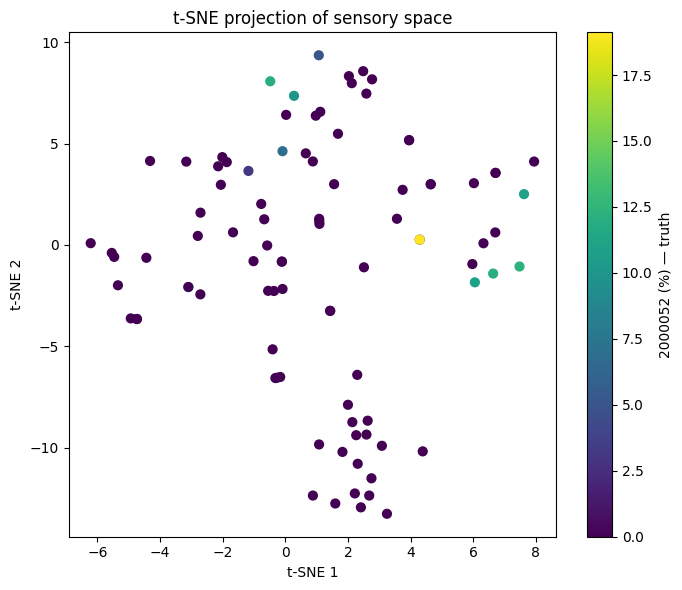

In [123]:
ing = "2000052"
plot_projection(proj2d, artifacts, ingredient=ing, color_by="truth", Ydf=Ydf)

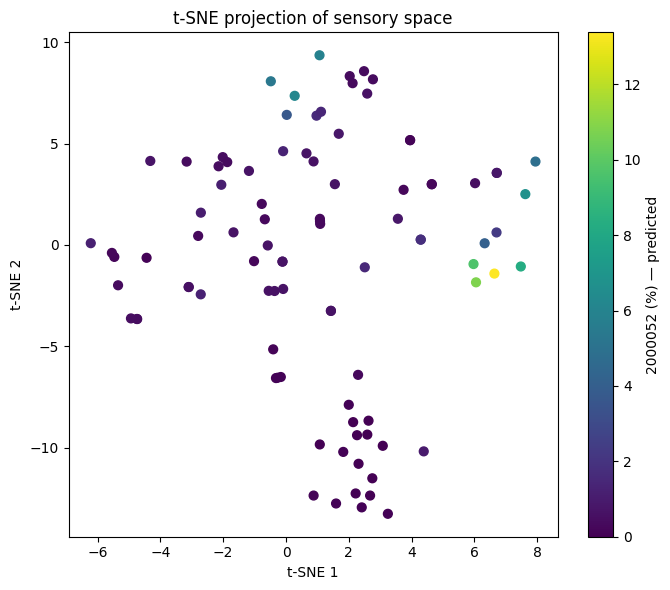

In [124]:
plot_projection(proj2d, artifacts, ingredient=ing, color_by="prediction", Xdf=Xdf)

In [131]:
Xdf.describe()

,acidez,amargor,aroma,astringencia,dulce,dureza,velocidad_fusion
count,51.000000,50.000000,86.000000,49.000000,87.000000,46.000000,87.000000
mean,0.696078,4.040000,4.901163,1.234694,3.695402,3.728261,4.591954
std,0.806712,1.236519,0.524796,0.750708,1.371123,1.114084,1.060739
min,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,2.000000
25%,0.000000,3.000000,5.000000,1.000000,2.500000,3.500000,4.000000
50%,0.500000,4.000000,5.000000,1.000000,4.000000,4.000000,5.000000
75%,1.000000,4.500000,5.000000,2.000000,4.750000,4.000000,5.500000
max,3.000000,7.000000,6.000000,3.000000,6.000000,5.000000,7.000000


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16912\3865265420.py:338: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


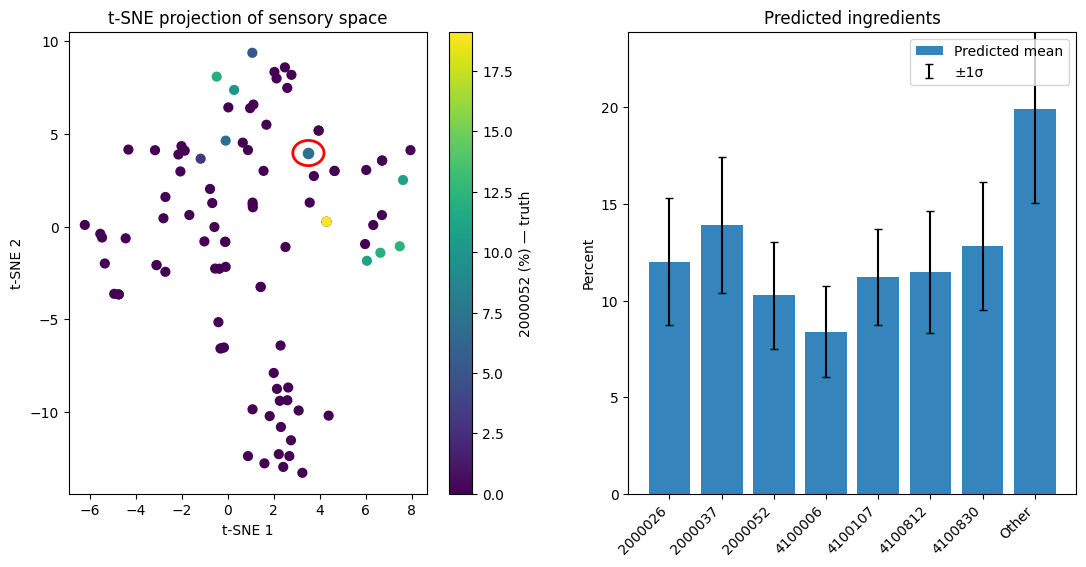

In [ ]:
sample_row = {
    "acidez": 4,     
    "amargor": 3,         
    "aroma": 2,
    "astringencia": 2,   
    "dulce": 4,
    "dureza": 7,
    "velocidad_fusion": 1
}
# sample_row = Xdf.iloc[9].drop(artifacts["id_col"])  # or a dict of sensory vars
plot_projection(proj2d, artifacts, ingredient="2000052", color_by="truth",
                Xdf=Xdf, Xs=Xs, nn=nn, sample_sens=sample_row, show_variance=True, Ydf=Ydf)
